# Dealing with imbalanced classes.

* The autoencoder neural network can learn the features of non-fraud instances. Then the trained model can be used to identify fraud instaces - Instances that have the highest rmse from the autoencoder learnt features will be classified as fraud. This work is modified from https://blogs.oracle.com/datascience/fraud-detection-using-autoencoders-in-keras-with-a-tensorflow-backend.


* 70% Recall, 12% Precision was obtained using an autoencoder with 1 hidden layer. 30 - 14 - 7- 14 - 30 describes the number of neurons in the layers. 


* I tried hypertuning using Randon Search CV. With Random Search we are improving autoencoder's learning of non-fraud features. IT ISN'T OPTIMIZING DETECTION OF FRAUD FEATURES DIRECTLY. 
* Perhaps this is why that tuning results donot improve detection. 
* (Use of hyperopt for parameter tuning can be a better way to directly optimize fraud detection with the autoencoder model. )


* Using the Kaggle Credit Card Fraud Detection dataset.
* Quoting from Kaggle:

    - The datasets contains transactions made by credit cards in September 2013 by european cardholders.This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

    - Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
    
    - Features V1-V28 are anonymized. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount.

## Imports & Read-in

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers

df=pd.read_csv('../input/creditcardfraud/creditcard.csv')

Using TensorFlow backend.


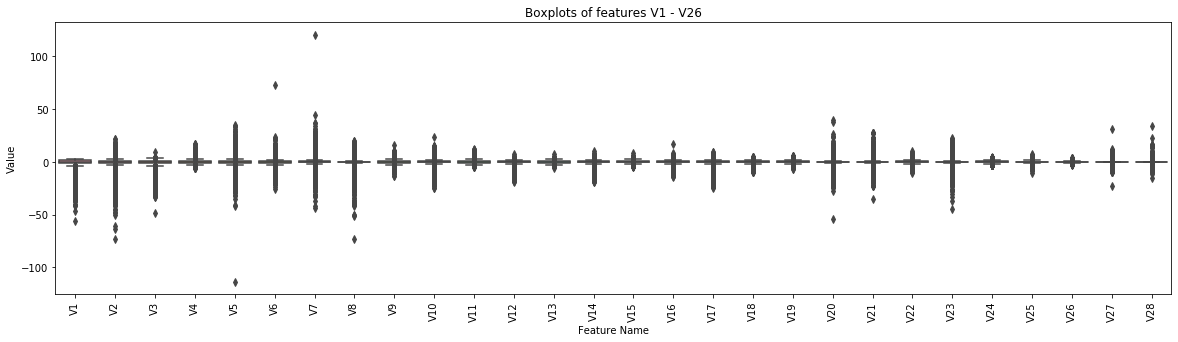

Text(0.5, 1.0, 'Boxplot of Amount feature')

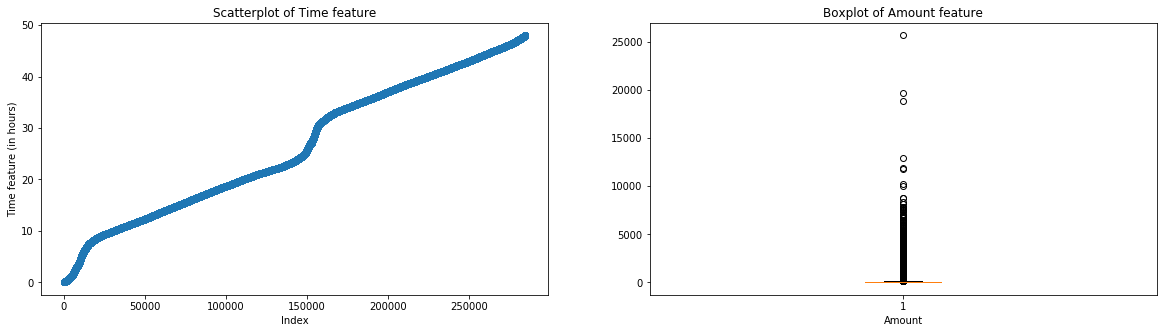

In [2]:
# Boxplot of variables V1 - V28
plt.figure(figsize=(20,5))
sns.boxplot(data=df.drop(['Time', 'Amount', 'Class'], axis=1))
plt.xticks(rotation=90)
plt.title('Boxplots of features V1 - V26')
plt.xlabel('Feature Name')
plt.ylabel('Value')
plt.show()

#datelist=pd.date_range("00:00:00", "23:59:59", freq="S")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(df.index, df['Time']/(60*60))
ax1.set_xlabel('Index')
ax1.set_ylabel('Time feature (in hours)')
ax1.set_title('Scatterplot of Time feature')
ax2.boxplot(df['Amount'])
ax2.set_xlabel('Amount')
ax2.set_title('Boxplot of Amount feature')

## Scale 'Time' & 'Amount'

In [3]:
df_norm = df
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

## Split non-fraud into X_train

In [4]:
X_train, X_test = train_test_split(df_norm, test_size=0.2, random_state=123)
X_train = X_train[X_train.Class == 0] #where normal transactions
X_train = X_train.drop(['Class'], axis=1) #drop the class column


y_test = X_test['Class'] #save the class column for the test set
X_test = X_test.drop(['Class'], axis=1) #drop the class column

X_train = X_train.values #transform to ndarray
X_test = X_test.values

## Build baseline autoencoder

In [5]:
# Information in 30 columns will be compressed into 14, then 7 dimensions. 
# Information will then be rebuilt in the decoder (a reverse process of the encoder)

nb_epoch = 100
batch_size = 128
input_dim = X_train.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, )) 
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [6]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

#tb = TensorBoard(log_dir='./logs',histogram_freq=0,write_graph=True,write_images=True)

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=2)


history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[cp, early_stopping_monitor]).history

Train on 227468 samples, validate on 56962 samples
Epoch 1/100
227468/227468 [==============================] - 7s 32us/step - loss: 0.8594 - accuracy: 0.4991 - val_loss: 0.8164 - val_accuracy: 0.5995
Epoch 2/100
227468/227468 [==============================] - 4s 19us/step - loss: 0.7665 - accuracy: 0.6176 - val_loss: 0.7808 - val_accuracy: 0.6164
Epoch 3/100
227468/227468 [==============================] - 5s 20us/step - loss: 0.7427 - accuracy: 0.6326 - val_loss: 0.7684 - val_accuracy: 0.6309
Epoch 4/100
227468/227468 [==============================] - 4s 18us/step - loss: 0.7334 - accuracy: 0.6413 - val_loss: 0.7629 - val_accuracy: 0.6375
Epoch 5/100
227468/227468 [==============================] - 4s 18us/step - loss: 0.7276 - accuracy: 0.6487 - val_loss: 0.7589 - val_accuracy: 0.6527
Epoch 6/100
227468/227468 [==============================] - 4s 18us/step - loss: 0.7230 - accuracy: 0.6575 - val_loss: 0.7541 - val_accuracy: 0.6603
Epoch 7/100
227468/227468 [======================

## Study model performance

In [7]:
autoencoder = load_model('autoencoder_fraud.h5')

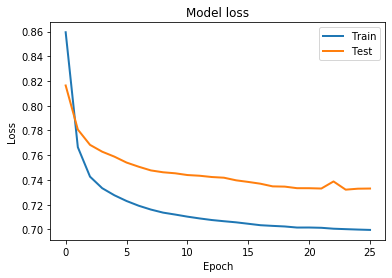

In [8]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

## Make predictions

In [9]:
test_x_predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - test_x_predictions, 2), axis=1)


error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test}) # save predictions to a new dataframe
error_df.head(15)

,Reconstruction_error,True_class
73129,0.212039,0
229597,0.379542,0
220218,0.313220,0
198374,1.190017,0
167980,0.448083,0
98465,0.567334,0
200436,0.907886,0
113404,0.992336,0
149063,0.651296,0
41420,0.239261,0


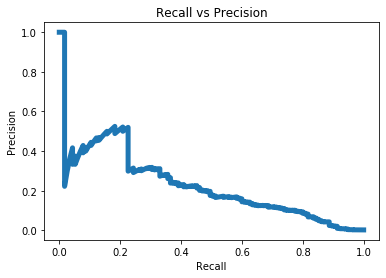

In [10]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

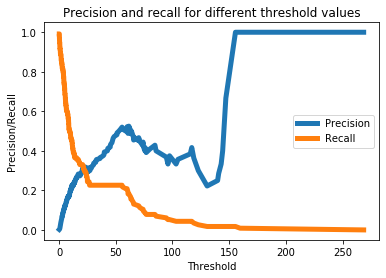

In [11]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

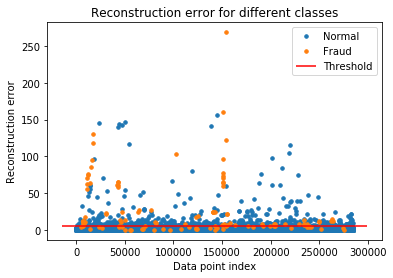

In [12]:
# All the Fraud + Non-fraud points above the threshold line of 4.9 will be classified as suspicious. 

threshold_fixed = 4.9 # based on above figure, threshold is set to 4.9
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [13]:
# Converting Reconstruction error to predictions based on the 4.9 threshold. 

y_pred = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


# We end up with a 71% Recall, Precision and thus F1 score is quite low. 

[[56227   620]
 [   33    82]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56847
           1       0.12      0.71      0.20       115

    accuracy                           0.99     56962
   macro avg       0.56      0.85      0.60     56962
weighted avg       1.00      0.99      0.99     56962



## Tuning

In [14]:
# Tuning model capacity: will adding more layers, different number of neurons improve model performance?

# A catch here is - with Random Search we are improving autoencoder's learning of non-fraud features. 
# IT ISN'T OPTIMIZING DETECTION OF FRAUD FEATURES DIRECTLY. 
# (Use of hyperopt for parameter tuning can support direct optimization of detection with the autoencoder model. )

def create_model_capacity(nl=1, nn=8):
    input_dim = X_train.shape[1]  # num of columns, 30
    encoding_dim = nn  # i.e. 7
    learning_rate = 1e-7

    input_layer = Input(shape=(input_dim, ))
    encoder = Dense(encoding_dim, activation="tanh",
                    activity_regularizer=regularizers.l1(learning_rate))(input_layer)
    if nl==1:
        encoder = Dense(int(encoding_dim/2), activation="relu")(encoder)
        encoder = Dense(int(encoding_dim/2), activation='tanh')(encoder)
    if nl==2:
        encoder = Dense(int(encoding_dim/2), activation="relu")(encoder)
        encoder = Dense(int(encoding_dim/4), activation="relu")(encoder)
        encoder = Dense(int(encoding_dim/4), activation='tanh')(encoder)
        encoder = Dense(int(encoding_dim/2), activation='tanh')(encoder)
    decoder = Dense(input_dim, activation='relu')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
    return autoencoder

# Create a KerasClassifier
nb_epoch = 100
batch_size = 128
model = KerasClassifier(build_fn=create_model_capacity)

# Define a series of parameters
params = dict(nl=[1,2], nn=[8,16,24])

# Define early stop monitor
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3)

# Create a random search cv object and fit it to the data
random_search = RandomizedSearchCV(model, param_distributions=params, cv=2)

In [15]:
random_search.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[cp, early_stopping_monitor])

C:\Users\Orpita Das\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Train on 113734 samples, validate on 56962 samples
Epoch 1/100
113734/113734 [==============================] - 3s 29us/step - loss: 0.9475 - accuracy: 0.3722 - val_loss: 0.9323 - val_accuracy: 0.4932
Epoch 2/100
113734/113734 [==============================] - 2s 19us/step - loss: 0.8721 - accuracy: 0.5163 - val_loss: 0.9003 - val_accuracy: 0.5274
Epoch 3/100
113734/113734 [==============================] - 2s 20us/step - loss: 0.8477 - accuracy: 0.5406 - val_loss: 0.8803 - val_accuracy: 0.5485
Epoch 4/100
113734/113734 [==============================] - 2s 21us/step - loss: 0.8307 - accuracy: 0.5512 - val_loss: 0.8661 - val_accuracy: 0.5478
Epoch 5/100
113734/113734 [==============================] - 2s 19us/step - loss: 0.8183 - accuracy: 0.5543 - val_loss: 0.8564 - val_accuracy: 0.5573
Epoch 6/100
113734/113734 [==============================] - 3s 22us/step - loss: 0.8083 - accuracy: 0.5612 - val_loss: 0.8480 - val_accuracy: 0.5628
Epoch 7/100
113734/113734 [======================

113734/113734 [==============================] - 2s 21us/step - loss: 0.8441 - accuracy: 0.3944 - val_loss: 0.8603 - val_accuracy: 0.3874
Epoch 10/100
113734/113734 [==============================] - 2s 21us/step - loss: 0.8423 - accuracy: 0.3975 - val_loss: 0.8588 - val_accuracy: 0.3899
Epoch 11/100
113734/113734 [==============================] - 2s 20us/step - loss: 0.8407 - accuracy: 0.3991 - val_loss: 0.8578 - val_accuracy: 0.3939
Epoch 12/100
113734/113734 [==============================] - 2s 21us/step - loss: 0.8396 - accuracy: 0.4004 - val_loss: 0.8569 - val_accuracy: 0.3940
Epoch 13/100
113734/113734 [==============================] - 2s 21us/step - loss: 0.8384 - accuracy: 0.4013 - val_loss: 0.8562 - val_accuracy: 0.3951
Epoch 14/100
113734/113734 [==============================] - 2s 20us/step - loss: 0.8377 - accuracy: 0.4033 - val_loss: 0.8548 - val_accuracy: 0.4002
Epoch 15/100
113734/113734 [==============================] - 2s 21us/step - loss: 0.8369 - accuracy: 0.405

113734/113734 [==============================] - 3s 23us/step - loss: 0.6867 - accuracy: 0.7151 - val_loss: 0.7317 - val_accuracy: 0.7125
Epoch 11/100
113734/113734 [==============================] - 3s 28us/step - loss: 0.6842 - accuracy: 0.7190 - val_loss: 0.7295 - val_accuracy: 0.7186
Epoch 12/100
113734/113734 [==============================] - 2s 21us/step - loss: 0.6822 - accuracy: 0.7217 - val_loss: 0.7271 - val_accuracy: 0.7225
Epoch 13/100
113734/113734 [==============================] - 2s 21us/step - loss: 0.6805 - accuracy: 0.7233 - val_loss: 0.7255 - val_accuracy: 0.7244
Epoch 14/100
113734/113734 [==============================] - 2s 20us/step - loss: 0.6791 - accuracy: 0.7266 - val_loss: 0.7260 - val_accuracy: 0.7261
Epoch 15/100
113734/113734 [==============================] - 2s 20us/step - loss: 0.6780 - accuracy: 0.7299 - val_loss: 0.7250 - val_accuracy: 0.7305
Epoch 16/100
113734/113734 [==============================] - 2s 21us/step - loss: 0.6771 - accuracy: 0.733

113734/113734 [==============================] - 2s 18us/step - loss: 0.7476 - accuracy: 0.6875 - val_loss: 0.7612 - val_accuracy: 0.6812
Epoch 7/100
113734/113734 [==============================] - 2s 18us/step - loss: 0.7430 - accuracy: 0.6906 - val_loss: 0.7574 - val_accuracy: 0.6860
Epoch 8/100
113734/113734 [==============================] - 2s 17us/step - loss: 0.7397 - accuracy: 0.6947 - val_loss: 0.7542 - val_accuracy: 0.6914
Epoch 9/100
113734/113734 [==============================] - 2s 17us/step - loss: 0.7362 - accuracy: 0.6939 - val_loss: 0.7501 - val_accuracy: 0.6870
Epoch 10/100
113734/113734 [==============================] - 2s 17us/step - loss: 0.7325 - accuracy: 0.6918 - val_loss: 0.7474 - val_accuracy: 0.6885
Epoch 11/100
113734/113734 [==============================] - 2s 17us/step - loss: 0.7294 - accuracy: 0.6952 - val_loss: 0.7454 - val_accuracy: 0.6933
Epoch 12/100
113734/113734 [==============================] - 2s 17us/step - loss: 0.7274 - accuracy: 0.6956 -

113734/113734 [==============================] - 2s 18us/step - loss: 0.6209 - accuracy: 0.8277 - val_loss: 0.6649 - val_accuracy: 0.8290
Epoch 23/100
113734/113734 [==============================] - 2s 18us/step - loss: 0.6203 - accuracy: 0.8285 - val_loss: 0.6647 - val_accuracy: 0.8262
Epoch 24/100
113734/113734 [==============================] - 2s 18us/step - loss: 0.6200 - accuracy: 0.8296 - val_loss: 0.6644 - val_accuracy: 0.8239
Epoch 25/100
113734/113734 [==============================] - 2s 18us/step - loss: 0.6195 - accuracy: 0.8292 - val_loss: 0.6632 - val_accuracy: 0.8252
Epoch 26/100
113734/113734 [==============================] - 2s 18us/step - loss: 0.6191 - accuracy: 0.8314 - val_loss: 0.6628 - val_accuracy: 0.8333
Epoch 27/100
113734/113734 [==============================] - 2s 18us/step - loss: 0.6191 - accuracy: 0.8332 - val_loss: 0.6626 - val_accuracy: 0.8311
Epoch 28/100
113734/113734 [==============================] - 2s 18us/step - loss: 0.6190 - accuracy: 0.832

113734/113734 [==============================] - 2s 20us/step - loss: 0.6485 - accuracy: 0.8296 - val_loss: 0.6667 - val_accuracy: 0.8270
Epoch 28/100
113734/113734 [==============================] - 2s 20us/step - loss: 0.6483 - accuracy: 0.8302 - val_loss: 0.6661 - val_accuracy: 0.8240
Epoch 29/100
113734/113734 [==============================] - 2s 21us/step - loss: 0.6481 - accuracy: 0.8293 - val_loss: 0.6648 - val_accuracy: 0.8308
Epoch 30/100
113734/113734 [==============================] - 3s 22us/step - loss: 0.6475 - accuracy: 0.8315 - val_loss: 0.6658 - val_accuracy: 0.8338
Epoch 31/100
113734/113734 [==============================] - 2s 21us/step - loss: 0.6475 - accuracy: 0.8316 - val_loss: 0.6649 - val_accuracy: 0.8278
Epoch 32/100
113734/113734 [==============================] - 3s 26us/step
Train on 113734 samples, validate on 56962 samples
Epoch 1/100
113734/113734 [==============================] - 3s 30us/step - loss: 0.9868 - accuracy: 0.1604 - val_loss: 0.9897 - val

113734/113734 [==============================] - 2s 21us/step - loss: 0.8788 - accuracy: 0.3205 - val_loss: 0.9212 - val_accuracy: 0.3167
Epoch 49/100
113734/113734 [==============================] - 3s 24us/step
Train on 113734 samples, validate on 56962 samples
Epoch 1/100
113734/113734 [==============================] - 3s 29us/step - loss: 1.0142 - accuracy: 0.1993 - val_loss: 0.9835 - val_accuracy: 0.3878
Epoch 2/100
113734/113734 [==============================] - 2s 21us/step - loss: 0.9478 - accuracy: 0.4373 - val_loss: 0.9499 - val_accuracy: 0.4444
Epoch 3/100
113734/113734 [==============================] - 2s 21us/step - loss: 0.9274 - accuracy: 0.4545 - val_loss: 0.9365 - val_accuracy: 0.4541
Epoch 4/100
113734/113734 [==============================] - 2s 21us/step - loss: 0.9183 - accuracy: 0.4596 - val_loss: 0.9307 - val_accuracy: 0.4574
Epoch 5/100
113734/113734 [==============================] - 2s 21us/step - loss: 0.9131 - accuracy: 0.4609 - val_loss: 0.9255 - val_acc

113734/113734 [==============================] - 3s 29us/step - loss: 0.8563 - accuracy: 0.5371 - val_loss: 0.8749 - val_accuracy: 0.5329
Epoch 53/100
113734/113734 [==============================] - 4s 32us/step - loss: 0.8563 - accuracy: 0.5367 - val_loss: 0.8744 - val_accuracy: 0.5333
Epoch 54/100
113734/113734 [==============================] - 2s 21us/step - loss: 0.8560 - accuracy: 0.5377 - val_loss: 0.8745 - val_accuracy: 0.5359
Epoch 55/100
113734/113734 [==============================] - 3s 23us/step - loss: 0.8561 - accuracy: 0.5383 - val_loss: 0.8749 - val_accuracy: 0.5314
Epoch 56/100
113734/113734 [==============================] - 2s 22us/step - loss: 0.8554 - accuracy: 0.5389 - val_loss: 0.8744 - val_accuracy: 0.5369
Epoch 57/100
113734/113734 [==============================] - 3s 23us/step - loss: 0.8553 - accuracy: 0.5395 - val_loss: 0.8740 - val_accuracy: 0.5341
Epoch 58/100
113734/113734 [==============================] - 2s 22us/step - loss: 0.8552 - accuracy: 0.539

113734/113734 [==============================] - 2s 22us/step - loss: 0.7412 - accuracy: 0.6158 - val_loss: 0.7861 - val_accuracy: 0.6204
Epoch 33/100
113734/113734 [==============================] - 2s 22us/step - loss: 0.7409 - accuracy: 0.6154 - val_loss: 0.7847 - val_accuracy: 0.6133
Epoch 34/100
113734/113734 [==============================] - 2s 22us/step - loss: 0.7404 - accuracy: 0.6166 - val_loss: 0.7849 - val_accuracy: 0.6112
Epoch 35/100
113734/113734 [==============================] - 3s 22us/step - loss: 0.7397 - accuracy: 0.6163 - val_loss: 0.7849 - val_accuracy: 0.6043
Epoch 36/100
113734/113734 [==============================] - 2s 21us/step - loss: 0.7391 - accuracy: 0.6179 - val_loss: 0.7838 - val_accuracy: 0.6154
Epoch 37/100
113734/113734 [==============================] - 3s 22us/step - loss: 0.7388 - accuracy: 0.6188 - val_loss: 0.7829 - val_accuracy: 0.6152
Epoch 38/100
113734/113734 [==============================] - 3s 23us/step - loss: 0.7383 - accuracy: 0.617

113734/113734 [==============================] - 2s 21us/step - loss: 0.7708 - accuracy: 0.6204 - val_loss: 0.7852 - val_accuracy: 0.6212
Epoch 33/100
113734/113734 [==============================] - 3s 22us/step - loss: 0.7673 - accuracy: 0.6249 - val_loss: 0.7823 - val_accuracy: 0.6248
Epoch 34/100
113734/113734 [==============================] - 3s 22us/step - loss: 0.7639 - accuracy: 0.6289 - val_loss: 0.7796 - val_accuracy: 0.6273
Epoch 35/100
113734/113734 [==============================] - 2s 21us/step - loss: 0.7621 - accuracy: 0.6321 - val_loss: 0.7785 - val_accuracy: 0.6292
Epoch 36/100
113734/113734 [==============================] - 2s 21us/step - loss: 0.7615 - accuracy: 0.6332 - val_loss: 0.7773 - val_accuracy: 0.6323
Epoch 37/100
113734/113734 [==============================] - 3s 23us/step - loss: 0.7603 - accuracy: 0.6336 - val_loss: 0.7768 - val_accuracy: 0.6340
Epoch 38/100
113734/113734 [==============================] - 2s 22us/step - loss: 0.7597 - accuracy: 0.634

113734/113734 [==============================] - 3s 26us/step
Train on 113734 samples, validate on 56962 samples
Epoch 1/100
113734/113734 [==============================] - 5s 40us/step - loss: 0.9079 - accuracy: 0.3012 - val_loss: 0.9073 - val_accuracy: 0.3662
Epoch 2/100
113734/113734 [==============================] - 3s 24us/step - loss: 0.8222 - accuracy: 0.5262 - val_loss: 0.8356 - val_accuracy: 0.5949
Epoch 3/100
113734/113734 [==============================] - 3s 26us/step - loss: 0.7832 - accuracy: 0.6124 - val_loss: 0.8177 - val_accuracy: 0.6110
Epoch 4/100
113734/113734 [==============================] - 3s 27us/step - loss: 0.7673 - accuracy: 0.6265 - val_loss: 0.8052 - val_accuracy: 0.6224
Epoch 5/100
113734/113734 [==============================] - 3s 30us/step - loss: 0.7579 - accuracy: 0.6358 - val_loss: 0.7976 - val_accuracy: 0.6311
Epoch 6/100
113734/113734 [==============================] - 3s 29us/step - loss: 0.7516 - accuracy: 0.6422 - val_loss: 0.7948 - val_accu

Epoch 16/100
113734/113734 [==============================] - 3s 24us/step - loss: 0.7435 - accuracy: 0.6737 - val_loss: 0.7605 - val_accuracy: 0.6727
Epoch 17/100
113734/113734 [==============================] - 3s 24us/step - loss: 0.7421 - accuracy: 0.6749 - val_loss: 0.7607 - val_accuracy: 0.6674
Epoch 18/100
113734/113734 [==============================] - 3s 24us/step - loss: 0.7414 - accuracy: 0.6752 - val_loss: 0.7592 - val_accuracy: 0.6732
Epoch 19/100
113734/113734 [==============================] - 3s 24us/step - loss: 0.7404 - accuracy: 0.6756 - val_loss: 0.7589 - val_accuracy: 0.6752
Epoch 20/100
113734/113734 [==============================] - 3s 24us/step - loss: 0.7401 - accuracy: 0.6765 - val_loss: 0.7590 - val_accuracy: 0.6689
Epoch 21/100
113734/113734 [==============================] - 3s 24us/step - loss: 0.7396 - accuracy: 0.6772 - val_loss: 0.7579 - val_accuracy: 0.6736
Epoch 22/100
113734/113734 [==============================] - 3s 24us/step - loss: 0.7390 - ac

227468/227468 [==============================] - 5s 22us/step - loss: 0.7384 - accuracy: 0.6797 - val_loss: 0.7642 - val_accuracy: 0.6744
Epoch 5/100
227468/227468 [==============================] - 5s 23us/step - loss: 0.7326 - accuracy: 0.6861 - val_loss: 0.7590 - val_accuracy: 0.6858
Epoch 6/100
227468/227468 [==============================] - 5s 22us/step - loss: 0.7284 - accuracy: 0.6930 - val_loss: 0.7553 - val_accuracy: 0.6894
Epoch 7/100
227468/227468 [==============================] - 5s 22us/step - loss: 0.7249 - accuracy: 0.6981 - val_loss: 0.7520 - val_accuracy: 0.6950
Epoch 8/100
227468/227468 [==============================] - 5s 22us/step - loss: 0.7220 - accuracy: 0.7040 - val_loss: 0.7502 - val_accuracy: 0.7002
Epoch 9/100
227468/227468 [==============================] - 5s 22us/step - loss: 0.7200 - accuracy: 0.7062 - val_loss: 0.7477 - val_accuracy: 0.7066
Epoch 10/100
227468/227468 [==============================] - 5s 23us/step - loss: 0.7186 - accuracy: 0.7058 - v

RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x00000152078F2240>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'nl': [1, 2], 'nn': [8, 16, 24]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [16]:
print("Best score: {:.4f} using {}".format(random_search.best_score_,random_search.best_params_))

Best score: 0.6293 using {'nn': 24, 'nl': 2}


In [17]:
random_search.cv_results_

{'mean_fit_time': array([119.80737758, 113.9898932 ,  93.52503681, 161.98834777,
        187.59869063, 144.59115303]),
 'std_fit_time': array([ 7.44352722, 27.62038636, 13.6123662 , 33.66503024, 47.2568711 ,
        35.19049156]),
 'mean_score_time': array([2.85669458, 2.49499702, 3.12640214, 2.83474588, 3.01017261,
        2.89383745]),
 'std_score_time': array([0.21090615, 0.3328135 , 0.07302356, 0.05053902, 0.05269098,
        0.05794716]),
 'param_nn': masked_array(data=[8, 16, 24, 8, 16, 24],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_nl': masked_array(data=[1, 1, 1, 2, 2, 2],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'nn': 8, 'nl': 1},
  {'nn': 16, 'nl': 1},
  {'nn': 24, 'nl': 1},
  {'nn': 8, 'nl': 2},
  {'nn': 16, 'nl': 2},
  {'nn': 24, 'nl': 2}],
 'split0_test_score': array([0.61577892, 0.60701287, 0.62785095, 0.39

In [23]:
# Reconstruct best autoencoder
nb_epoch = 100
batch_size = 128
input_dim = X_train.shape[1] #num of columns, 30
encoding_dim = 24
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, )) 
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(int(encoding_dim/2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim/4), activation='tanh')(encoder)
encoder = Dense(int(encoding_dim/4), activation="relu")(encoder)
decoder = Dense(int(encoding_dim/2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

#tb = TensorBoard(log_dir='./logs',histogram_freq=0,write_graph=True,write_images=True)

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3)


history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[cp, early_stopping_monitor]).history

Train on 227468 samples, validate on 56962 samples
Epoch 1/100
227468/227468 [==============================] - 6s 26us/step - loss: 0.8192 - accuracy: 0.5600 - val_loss: 0.7840 - val_accuracy: 0.6233
Epoch 2/100
227468/227468 [==============================] - 7s 29us/step - loss: 0.7437 - accuracy: 0.6362 - val_loss: 0.7614 - val_accuracy: 0.6417
Epoch 3/100
227468/227468 [==============================] - 5s 24us/step - loss: 0.7278 - accuracy: 0.6493 - val_loss: 0.7522 - val_accuracy: 0.6512
Epoch 4/100
227468/227468 [==============================] - 6s 25us/step - loss: 0.7204 - accuracy: 0.6582 - val_loss: 0.7465 - val_accuracy: 0.6604
Epoch 5/100
227468/227468 [==============================] - 6s 25us/step - loss: 0.7159 - accuracy: 0.6665 - val_loss: 0.7436 - val_accuracy: 0.6678
Epoch 6/100
227468/227468 [==============================] - 6s 25us/step - loss: 0.7127 - accuracy: 0.6723 - val_loss: 0.7399 - val_accuracy: 0.6758
Epoch 7/100
227468/227468 [======================

In [24]:
autoencoder = load_model('autoencoder_fraud.h5')

In [25]:
test_x_predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})
error_df.head()

,Reconstruction_error,True_class
73129,0.202989,0
229597,0.389023,0
220218,0.291670,0
198374,1.073197,0
167980,0.469817,0


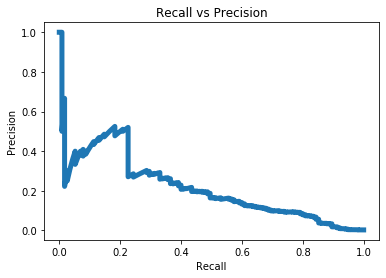

In [26]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

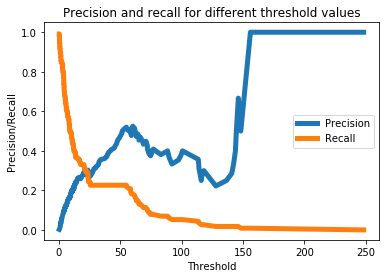

In [27]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

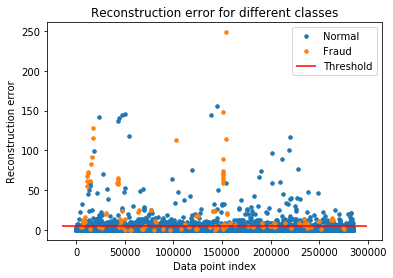

In [28]:
# All the Fraud + Non-fraud points above the threshold line of 4.9 will be classified as suspicious. 

threshold_fixed = 4.9 # based on above figure, threshold is set to 4.9
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [29]:
threshold_fixed=4.9
y_pred = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[56231   616]
 [   38    77]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56847
           1       0.11      0.67      0.19       115

    accuracy                           0.99     56962
   macro avg       0.56      0.83      0.59     56962
weighted avg       1.00      0.99      0.99     56962



In [ ]:
def create_model_parameters(learning_rate=0.001, batch_size=128, activation='tanh'):
    encoding_dim = 24
    
    input_layer = Input(shape=(input_dim, )) 
    encoder = Dense(encoding_dim, activation=activation, activity_regularizer=regularizers.l1(learning_rate))(input_layer)
    encoder = Dense(int(encoding_dim/2), activation=activation)(encoder)
    decoder = Dense(int(encoding_dim/4), activation=activation)(encoder)
    encoder = Dense(int(encoding_dim/4), activation=activation)(encoder)
    decoder = Dense(int(encoding_dim/2), activation=activation)(encoder)
    decoder = Dense(input_dim, activation=activation)(decoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    
    autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

    return autoencoder

# Create a KerasClassifier
model = KerasClassifier(build_fn = create_model_parameters)

# Define a series of parameters
params = dict(batch_size=[48, 128, 168], activation=['relu','tanh', 'elu'], learning_rate=[1e-9,1e-7,1e-4])

# Define early stop monitor
early_stopping_monitor=EarlyStopping(monitor='val_loss', patience=3)

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

# Create a random search cv object and fit it to the data
random_search = RandomizedSearchCV(model, param_distributions=params, cv=3)

random_search.fit(X_train, X_train,
                    epochs=100,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[cp, early_stopping_monitor])

Train on 151645 samples, validate on 56962 samples
Epoch 1/100
151645/151645 [==============================] - 4s 28us/step - loss: 0.8619 - accuracy: 0.3647 - val_loss: 0.8354 - val_accuracy: 0.4618
Epoch 2/100
151645/151645 [==============================] - 3s 20us/step - loss: 0.7780 - accuracy: 0.4912 - val_loss: 0.7996 - val_accuracy: 0.5342
Epoch 3/100
151645/151645 [==============================] - 3s 20us/step - loss: 0.7442 - accuracy: 0.5591 - val_loss: 0.7653 - val_accuracy: 0.5985
Epoch 4/100
151645/151645 [==============================] - 3s 22us/step - loss: 0.7152 - accuracy: 0.6476 - val_loss: 0.7511 - val_accuracy: 0.6714
Epoch 5/100
151645/151645 [==============================] - 3s 20us/step - loss: 0.7062 - accuracy: 0.6802 - val_loss: 0.7440 - val_accuracy: 0.6900
Epoch 6/100
151645/151645 [==============================] - 3s 20us/step - loss: 0.7011 - accuracy: 0.6950 - val_loss: 0.7402 - val_accuracy: 0.6969
Epoch 7/100
151645/151645 [======================

151645/151645 [==============================] - 3s 23us/step - loss: 0.7042 - accuracy: 0.6873 - val_loss: 0.7383 - val_accuracy: 0.6847
Epoch 10/100
151645/151645 [==============================] - 3s 22us/step - loss: 0.7025 - accuracy: 0.6908 - val_loss: 0.7368 - val_accuracy: 0.6885
Epoch 11/100
151645/151645 [==============================] - 3s 22us/step - loss: 0.7015 - accuracy: 0.6925 - val_loss: 0.7361 - val_accuracy: 0.6927
Epoch 12/100
151645/151645 [==============================] - 3s 21us/step - loss: 0.7003 - accuracy: 0.6940 - val_loss: 0.7361 - val_accuracy: 0.6980
Epoch 13/100
151645/151645 [==============================] - 3s 20us/step - loss: 0.6992 - accuracy: 0.6960 - val_loss: 0.7329 - val_accuracy: 0.6946
Epoch 14/100
151645/151645 [==============================] - 3s 20us/step - loss: 0.6959 - accuracy: 0.6988 - val_loss: 0.7289 - val_accuracy: 0.6983
Epoch 15/100
151645/151645 [==============================] - 3s 20us/step - loss: 0.6930 - accuracy: 0.703

151646/151646 [==============================] - 3s 20us/step - loss: 0.7414 - accuracy: 0.7301 - val_loss: 0.7614 - val_accuracy: 0.7286
Epoch 35/100
151646/151646 [==============================] - 4s 24us/step - loss: 0.7411 - accuracy: 0.7294 - val_loss: 0.7615 - val_accuracy: 0.7290
Epoch 36/100
151646/151646 [==============================] - 4s 27us/step - loss: 0.7408 - accuracy: 0.7295 - val_loss: 0.7624 - val_accuracy: 0.7231
Epoch 37/100
151646/151646 [==============================] - 4s 25us/step - loss: 0.7408 - accuracy: 0.7288 - val_loss: 0.7612 - val_accuracy: 0.7304
Epoch 38/100
151646/151646 [==============================] - 4s 24us/step - loss: 0.7405 - accuracy: 0.7293 - val_loss: 0.7606 - val_accuracy: 0.7265
Epoch 39/100
151646/151646 [==============================] - 4s 24us/step - loss: 0.7404 - accuracy: 0.7283 - val_loss: 0.7602 - val_accuracy: 0.7284
Epoch 40/100
151646/151646 [==============================] - 4s 28us/step - loss: 0.7396 - accuracy: 0.729

151645/151645 [==============================] - 3s 21us/step - loss: 0.5791 - accuracy: 0.3584 - val_loss: 0.6136 - val_accuracy: 0.3553
Epoch 44/100
151645/151645 [==============================] - 3s 20us/step - loss: 0.5787 - accuracy: 0.3573 - val_loss: 0.6131 - val_accuracy: 0.3534
Epoch 45/100
151645/151645 [==============================] - 4s 28us/step - loss: 0.5783 - accuracy: 0.3560 - val_loss: 0.6131 - val_accuracy: 0.3505
Epoch 46/100
151645/151645 [==============================] - 4s 29us/step - loss: 0.5780 - accuracy: 0.3557 - val_loss: 0.6124 - val_accuracy: 0.3523
Epoch 47/100
151645/151645 [==============================] - 4s 25us/step - loss: 0.5776 - accuracy: 0.3543 - val_loss: 0.6122 - val_accuracy: 0.3526
Epoch 48/100
151645/151645 [==============================] - 4s 24us/step - loss: 0.5774 - accuracy: 0.3544 - val_loss: 0.6117 - val_accuracy: 0.3512
Epoch 49/100
151645/151645 [==============================] - 3s 21us/step - loss: 0.5770 - accuracy: 0.353